# Single-cell analysis and prediction of tumor-infiltrating immune cells
Author: Margaret Paiva

### Dependencies and setting

In [57]:
import numpy as np
import pandas as pd
import scanpy as sc
from collections import OrderedDict
import scintegral.classifier as scint_classifier
import scintegral.utils as scint_utils
import warnings
import matplotlib.pyplot as plt

In [58]:
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.6 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


### Data

In [59]:
# table with clinical responses
# complete response (CR) and partial response (PR) for responders, 
# stable disease (SD) and progressive disease (PD) for nonresponders
meta = pd.read_csv('data/GSE120575_patient_ID_single_cells.txt.gz', 
                   sep="\t", encoding="latin", 
                   skiprows=19).iloc[:, :7]
# remove additional information after sample table
meta = meta.iloc[:16291]

# rename columns by removing the `characteristics: ` prefix to make it more concise
meta.columns = [x.replace("characteristics: ", "") for x in meta.columns]

# rename the long `patient ID (...)` column to simple sample_id
meta.rename(
    columns={"patinet ID (Pre=baseline; Post= on treatment)": "sample_id"},
    inplace=True
)

# add columns that seperate sample_id for later analysis
meta["patient_id"] = [x.split("_")[1] for x in meta.sample_id]
meta["time_point"] = [x.split("_")[0] for x in meta.sample_id]

meta

Sample name                      title           source name  \
0          Sample 1                 A10_P3_M11  Melanoma single cell   
1          Sample 2                 A11_P1_M11  Melanoma single cell   
2          Sample 3                 A11_P3_M11  Melanoma single cell   
3          Sample 4                 A11_P4_M11  Melanoma single cell   
4          Sample 5                 A12_P3_M11  Melanoma single cell   
...             ...                        ...                   ...   
16286  Sample 16287  H5_P5_M67_L001_T_enriched  Melanoma single cell   
16287  Sample 16288  H6_P5_M67_L001_T_enriched  Melanoma single cell   
16288  Sample 16289  H7_P5_M67_L001_T_enriched  Melanoma single cell   
16289  Sample 16290  H8_P5_M67_L001_T_enriched  Melanoma single cell   
16290  Sample 16291  H9_P5_M67_L001_T_enriched  Melanoma single cell   

           organism sample_id       response     therapy patient_id time_point  
0      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
1      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
2      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
3      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
4      Homo sapiens    Pre_P1      Responder  anti-CTLA4         P1        Pre  
...             ...       ...            ...         ...        ...        ...  
16286  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16287  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16288  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16289  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  
16290  Homo sapiens   Post_P6  Non-responder    anti-PD1         P6       Post  

[16291 rows x 9 columns]

In [60]:
# table with sc gene expression
# ge = pd.read_csv('data/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz', 
#                  sep="\t", skiprows=3)

adata = sc.read_text('data/GSE120575_melanoma_scrna_tpm.txt.gz').transpose()
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16291 × 55737

In [61]:
adata.obs

Empty DataFrame
Columns: []
Index: [A10_P3_M11, A11_P1_M11, A11_P3_M11, A11_P4_M11, A12_P3_M11, A12_P6_M11, A2_P1_M11, A2_P4_M11, A3_P1_M11, A3_P3_M11, A4_P3_M11, A4_P4_M11, A4_P6_M11, A5_P4_M11, A5_P5_M11, A6_P1_M11, A6_P4_M11, A6_P6_M11, A7_P2_M11, A7_P6_M11, A8_P1_M11, A8_P6_M11, A9_P1_M11, A9_P4_M11, B10_P1_M11, B10_P3_M11, B10_P4_M11, B10_P6_M11, B11_P6_M11, B12_P3_M11, B12_P4_M11, B1_P2_M11, B1_P4_M11, B2_P1_M11, B2_P5_M11, B2_P6_M11, B3_P1_M11, B3_P5_M11, B4_P1_M11, B4_P4_M11, B4_P6_M11, B5_P1_M11, B5_P6_M11, B6_P1_M11, B7_P4_M11, B8_P6_M11, B9_P2_M11, C10_P4_M11, C10_P6_M11, C11_P4_M11, C11_P6_M11, C12_P4_M11, C1_P3_M11, C1_P4_M11, C2_P6_M11, C3_P1_M11, C4_P1_M11, C4_P3_M11, C4_P4_M11, C4_P6_M11, C5_P3_M11, C5_P5_M11, C5_P6_M11, C6_P2_M11, C6_P3_M11, C6_P4_M11, C7_P3_M11, C7_P5_M11, C7_P6_M11, C8_P3_M11, C8_P5_M11, C9_P1_M11, C9_P2_M11, C9_P4_M11, D10_P1_M11, D10_P6_M11, D11_P6_M11, D12_P6_M11, D1_P1_M11, D1_P4_M11, D1_P6_M11, D2_P4_M11, D2_P6_M11, D3_P1_M11, D3_P3_M11, D3_P6_M11, D4_P1_M11, D4_P3_M11, D4_P4_M11, D4_P6_M11, D5_P4_M11, D5_P5_M11, D5_P6_M11, D6_P1_M11, D6_P3_M11, D6_P5_M11, D6_P6_M11, D7_P3_M11, D7_P5_M11, D8_P2_M11, ...]

[16291 rows x 0 columns]

In [62]:
adata.var

Empty DataFrame
Columns: []
Index: [TSPAN6, TNMD, DPM1, SCYL3, C1orf112, FGR, CFH, FUCA2, GCLC, NFYA, STPG1, NIPAL3, LAS1L, ENPP4, SEMA3F, CFTR, ANKIB1, CYP51A1, KRIT1, RAD52, MYH16, BAD, LAP3, CD99, HS3ST1, AOC1, WNT16, HECW1, MAD1L1, LASP1, SNX11, TMEM176A, M6PR, KLHL13, CYP26B1, ICA1, DBNDD1, ALS2, CASP10, CFLAR, TFPI, NDUFAF7, RBM5, MTMR7, SLC7A2, ARF5, SARM1, POLDIP2, PLXND1, AK2, CD38, FKBP4, KDM1A, RBM6, CAMKK1, RECQL, CCDC132, HSPB6, ARHGAP33, NDUFAB1, PDK4, SLC22A16, ZMYND10, ABCB5, ARX, SLC25A13, ST7, CDC27, SLC4A1, CALCR, HCCS, DVL2, PRSS22, UPF1, SKAP2, SLC25A5, CCDC109B, HOXA11, POLR2J, DHX33, MEOX1, THSD7A, LIG3, RPAP3, ACSM3, AC004381.6, CIAPIN1, SPPL2B, FAM214B, COPZ2, PRKAR2B, MSL3, CREBBP, BZRAP1, MPO, PON1, GCFC2, WDR54, CROT, ABCB4, ...]

[55737 rows x 0 columns]

In [63]:
adata.X[0:5, 0:10]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 9.24, 0.  , 0.  , 0.  , 0.  , 0.  , 1.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 7.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [64]:
adata.X.shape

(16291, 55737)

In [65]:
# Add meta data to adata.obs
adata.obs = adata.obs.merge(meta, 
                            left_index=True, 
                            right_on='title').set_index('title')
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  
title                                 
A10_P3_M11                       Pre  
A11_P1_M11                       Pre  
A11_P3_M11                       Pre  
A11_P4_M11                       Pre  
A12_P3_M11                       Pre  
...                              ...  
H5_P5_M67_L001_T_enriched       Post  
H6_P5_M67_L001_T_enriched       Post  
H7_P5_M67_L001_T_enriched       Post  
H8_P5_M67_L001_T_enriched       Post  
H9_P5_M67_L001_T_enriched       Post  

[16291 rows x 8 columns]

In [66]:
# Get the statistics of the data
# These TPM values; no logarithmizing
mean_expr = pd.Series(adata.X.mean(axis=0))
mean_expr.index = adata.var.index
mean_expr.describe()

count    55737.000000
mean         0.275007
std          0.842511
min          0.000000
25%          0.001366
50%          0.007080
75%          0.105477
max         16.430943
dtype: float64

### Preprocessing

Basic filter:

In [67]:
# Each cell should have a minimum genes expressed;
# Otherwise, they are dropouts
sc.pp.filter_cells(adata, min_genes=200)
# Each genes should be expressed in at least a certain number of cells
# to be considered as an expressed gene
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 16291 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes'
    var: 'n_cells'

Find and filter genes that are potentially noisy: 

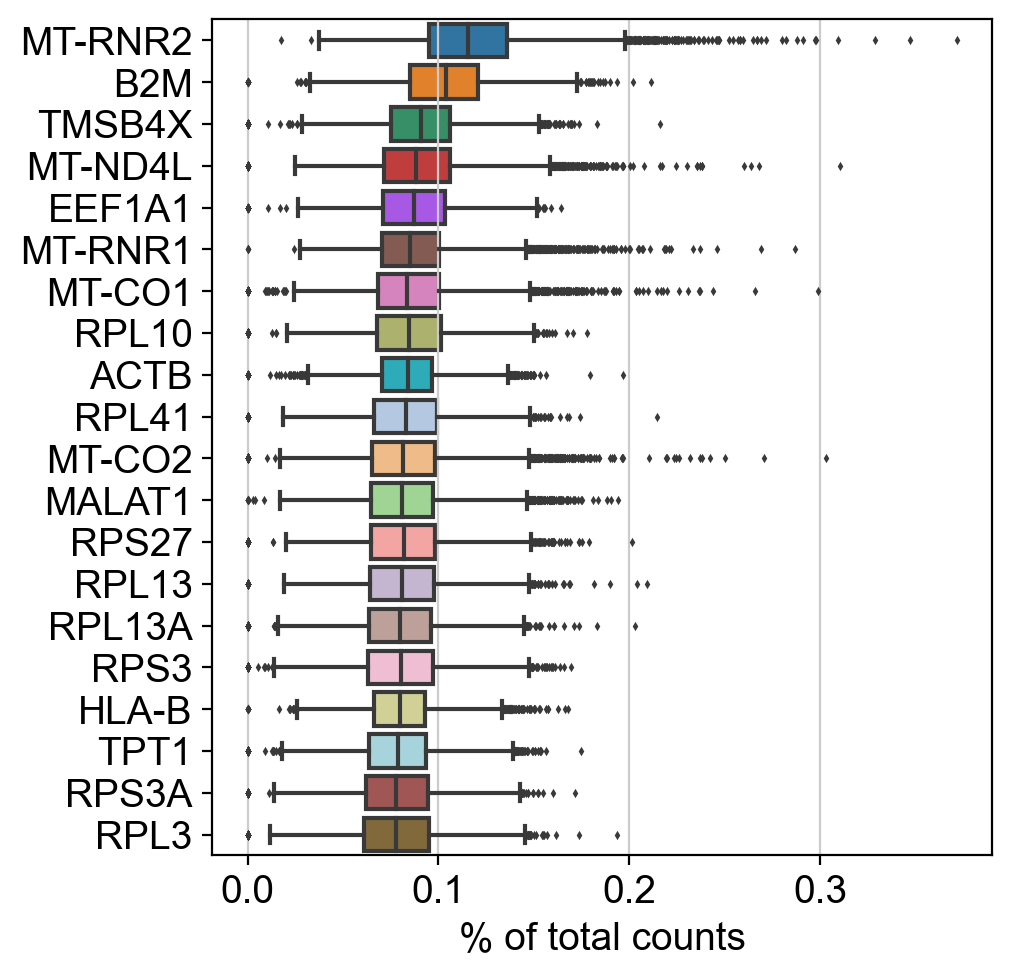

In [68]:
# First, plot genes that yield the highest fraction of counts in each single cell, 
# across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [69]:
# High proportions of mitochondrial genes are indicative of poor-quality cells
# possibly because of loss of cytoplasmic RNA from perforated cells

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=['mt'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)
adata

AnnData object with n_obs × n_vars = 16291 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'source name' as categorical
/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'organism' as categorical
/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories i

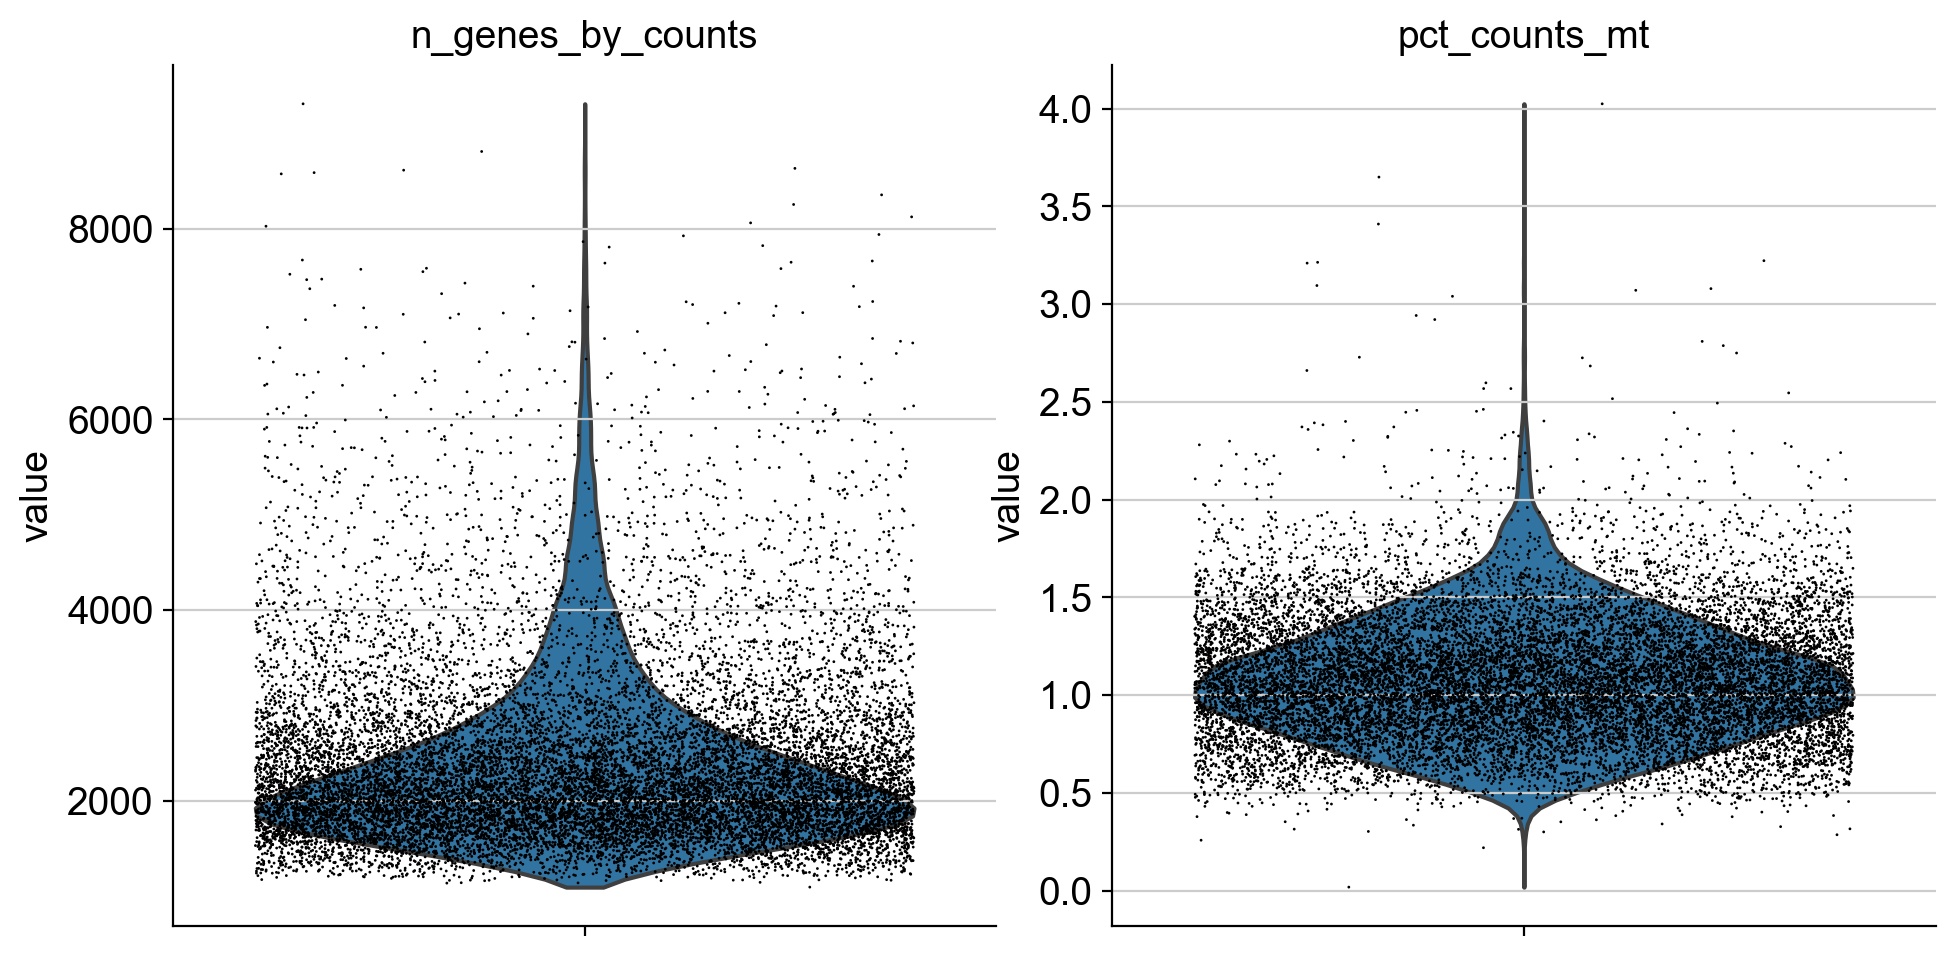

In [70]:
# "n_genes_by_counts" is the genes with various counts expressed in one cell
# too many counts means that that gene could be a noisy genes
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated")
    
sc.pl.violin(adata, ['n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated")

In [71]:
# filtering noisy genes (samples with too many genes expressed)
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
# filtering samples with too many mitochondrial genes
adata = adata[adata.obs.pct_counts_mt < 2.5, :]
adata

View of AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Automatic cell annotation

scIntegral does not need the data to be normalized. 

In [133]:
marker_dict = {
    'CD8+ T (cytotoxic)':['CD8A', 'CD8B', 'KLRG1', 'PRF1', 'FCGR3A', 'CX3CR1'],
    'CD8+ T (exhausted)':['CD8A', 'CD8B', 'PDCD1', 'CTLA4', 'LAG3', 'LAYN', 'HAVCR2'],
    'CD4+ Treg':['FOXP3', 'IL2RA', 'CD4'], 
    'CD4+ T (naive/memory)':['IL7R', 'TCF7', 'CD4'],
    'CD8+ T (naive/memory)':['IL7R', 'TCF7', 'CD8A', 'CD8B'],
    'B cells':['CD19', 'MS4A1'],
    'Plasma cells': ['IGJ', 'SDC1', 'IGLV6-57'],
    'NK cells':['SPC25', 'CDCA5'],
    'Dendritic cells':['CLEC4C', 'PTCRA', 'ITGAX', 'THBD'],
    'Macrophages':['CD74', 'MARCO', 'CSF1R', 'CD68'] 
}

# # This set works: keep this as a record if changes are needed
# marker_dict = {
# 	'CD4+ T cells':['CD4', 'CXCR3'],
#     'CD8+ T cells':['CD8A', 'CD8B'],
#     'Regulatory T cells':['FOXP3', 'IL2RA'],
#     'Memory T cells':['TCF7', 'LEF1'],
# #     'Exhausted T cells':['PDCD1', 'BTLA'],
#     'B cells': ['CD19', 'MS4A1'],
#     'Dendritic cells':['ITGAX', 'THBD'],
#     'Macrophages':['CD74', 'CD68'] 
# }

# KEEP!! Best results:
# marker_dict = {
#     'CD8+ T cells':['CD8A', 'CD8B'],
# #     'CD4+ T cells':['CD4', 'CXCR3'],
#     'Regulatory T cells':['FOXP3', 'IL2RA'], # mostly CD4+ Treg
# #     'Memory T cells':['TCF7', 'LEF1'],
# #     'Exhausted T cells':['PDCD1', 'BTLA'],
#     'B cells':['CD19', 'MS4A1'],
#     'Plasma cells': ['IGJ', 'SDC1', 'IGLV6-57'],
# #     'NK cells': ['SPC25', 'CDCA5', 'FCGR3A', 'GNLY', 'NKG7'],
#     'NK cells':['SPC25', 'CDCA5'],
#     'Dendritic cells':['CLEC4C', 'PTCRA', 'ITGAX', 'THBD'],
# #     'Monocytes':['CD14'],
#     'Monocytes/Macrophages':['CD74', 'MARCO', 'CD68'] 
# }

# # The following has NK cells
# # It may be better to mark them during subgrouping
# marker_dict = {
# 	'CD4+ T cells':['CD4', 'CXCR3'],
#     'CD8+ T cells':['CD8A', 'CD8B'],
#     'Regulatory T cells':['FOXP3', 'IL2RA'],
#     'Memory T cells':['TCF7', 'LEF1'],
#     'Exhausted T cells':['PDCD1', 'BTLA'],
#     'B cells': ['CD19', 'MS4A1'],
#     'Dendritic cells':['ITGAX', 'THBD'],
#     'Macrophages':['CD74', 'CD68'],
#     'NK cells':['GNLY', 'NKG7']
# }

# scanpy
# B-cell: CD79A, MS4A1
# Plasma: IGJ (JCHAIN)
# T-cell: CD3D
# NK: GNLY, NKG7
# Myeloid: CST3, LYZ
# Monocytes: FCGR3A
# Dendritic: FCER1A

# "Molecular and cellular insights into T cell exhaustion"
# Whereas senescent CD8+ T cells are often defined by 
# high expression of markers such as KLRG1 and/or CD57, 
# exhausted CD8+ T cells tend to have low expression of these markers. 
# Furthermore, exhausted CD8+ T cells have 
# high expression of PD1, whereas senescent cells do not.

# "PD-1 and BTLA and CD8+ T-cell “exhaustion” in cancer"
# The elevated expression of PD-1, BTLA, 
# and other co-inhibitory molecules on T cells from cancer patients 
# has become an accepted signature for a state called T-cell “exhaustion” 

# "Defining T cell states associated with 
# response to checkpoint immunotherapy in melanoma"
# CD8_G with increased expression of genes linked 
# to memory, activation and cell survival (e.g. IL7R, TCF7, REL, FOXP1, FOSL2 and STAT4) 
# and reduced expression of co-inhibitory molecules; 
# and CD8_B enriched for genes linked 
# to cell exhaustion (e.g. CD38, HAVCR2, ENTPD1, PDCD1, BATF, LAG3, CTLA4 and PTPN6) 

In [134]:
marker_onehot = scint_utils.marker_input_creator(marker_dict)
marker_onehot

CD8+ T (cytotoxic)  CD8+ T (exhausted)  CD4+ Treg  \
CD8A                       1                   1          0   
CD8B                       1                   1          0   
KLRG1                      1                   0          0   
PRF1                       1                   0          0   
FCGR3A                     1                   0          0   
CX3CR1                     1                   0          0   
CD8A                       1                   1          0   
CD8B                       1                   1          0   
PDCD1                      0                   1          0   
CTLA4                      0                   1          0   
LAG3                       0                   1          0   
LAYN                       0                   1          0   
HAVCR2                     0                   1          0   
FOXP3                      0                   0          1   
IL2RA                      0                   0          1   
CD4                        0                   0          1   
IL7R                       0                   0          0   
TCF7                       0                   0          0   
CD4                        0                   0          1   
IL7R                       0                   0          0   
TCF7                       0                   0          0   
CD8A                       1                   1          0   
CD8B                       1                   1          0   
CD19                       0                   0          0   
MS4A1                      0                   0          0   
IGJ                        0                   0          0   
SDC1                       0                   0          0   
IGLV6-57                   0                   0          0   
SPC25                      0                   0          0   
CDCA5                      0                   0          0   
CLEC4C                     0                   0          0   
PTCRA                      0                   0          0   
ITGAX                      0                   0          0   
THBD                       0                   0          0   
CD74                       0                   0          0   
MARCO                      0                   0          0   
CSF1R                      0                   0          0   
CD68                       0                   0          0   

          CD4+ T (naive/memory)  CD8+ T (naive/memory)  B cells  Plasma cells  \
CD8A                          0                      1        0             0   
CD8B                          0                      1        0             0   
KLRG1                         0                      0        0             0   
PRF1                          0                      0        0             0   
FCGR3A                        0                      0        0             0   
CX3CR1                        0                      0        0             0   
CD8A                          0                      1        0             0   
CD8B                          0                      1        0             0   
PDCD1                         0                      0        0             0   
CTLA4                         0                      0        0             0   
LAG3                          0                      0        0             0   
LAYN                          0                      0        0             0   
HAVCR2                        0                      0        0             0   
FOXP3                         0                      0        0             0   
IL2RA                         0                      0        0             0   
CD4                           1                      0        0             0   
IL7R                          1                      1        0             0   
TCF7                          1                      1        0             0   
CD4          

In [74]:
# bdata = adata[:, marker_onehot.index].copy()
# bdata

In [96]:
# cov_mat contains the batch information
cov_mat = pd.get_dummies(adata.obs['sample_id'])
cov_mat = pd.DataFrame(cov_mat.sum(axis=1)) # after checking, all samples are from the same batch
cov_mat

0
title                       
A10_P3_M11                 1
A11_P1_M11                 1
A11_P3_M11                 1
A11_P4_M11                 1
A12_P3_M11                 1
...                       ..
H5_P5_M67_L001_T_enriched  1
H6_P5_M67_L001_T_enriched  1
H7_P5_M67_L001_T_enriched  1
H8_P5_M67_L001_T_enriched  1
H9_P5_M67_L001_T_enriched  1

[16215 rows x 1 columns]

In [76]:
cov_mat.shape[1]

1

In [97]:
# A size factor may be defined manually as 
# scaled library size (total UMI count) 
# and should not be placed on the log scale, 
# as the model will do this. 
# The library size should be computed before any gene subsetting
# scIntegral paper used computeSumFactors from R package
lib_size = adata.X.sum(1)
size_factor = lib_size / np.mean(lib_size)
size_factor.shape

(16215,)

In [135]:
# pred = scint_classifier.classify_cells(expr_mat=bdata.X,
#                                       cov_mat=cov_mat.to_numpy(),
#                                       size_factor=size_factor,
#                                       marker_onehot=marker_onehot,
#                                       prior_mean=4, # default 2
#                                       prior_width=0.1, # default 0.05
#                                       disp_init=4 # default 2
#                                       )

pred = scint_classifier.classify_cells(expr_mat=adata[:, marker_onehot.index].X,
                                      cov_mat=cov_mat.to_numpy(),
                                      size_factor=size_factor,
                                      marker_onehot=marker_onehot,
                                      prior_mean=4, # default 2
                                      prior_width=0.1, # default 0.05
                                      disp_init=4 # default 2
                                      )
pred

(['CD4+ T (naive/memory)',
  'B cells',
  'CD4+ T (naive/memory)',
  'CD4+ Treg',
  'CD4+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'others',
  'CD8+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'CD8+ T (exhausted)',
  'CD8+ T (naive/memory)',
  'CD4+ Treg',
  'Dendritic cells',
  'CD8+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'CD8+ T (naive/memory)',
  'CD8+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD4+ Treg',
  'CD4+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'CD8+ T (exhausted)',
  'CD8+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'CD8+ T (naive/memory)',
  'CD8+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'CD4+ T (naive/memory)',
  'CD8+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD8+ T (exhausted)',
  'CD4+ Treg',
  'CD4+ T (naive/memory)',
  'CD8+ T (naive/memory)',
  'CD4+ T (naive/memory)',
  'CD4+ Treg',
  'Macrophages',
  'CD8+ T (exhausted)',
 

In [79]:
len(pred)

2

In [80]:
len(pred[0])

16215

In [136]:
# bdata.obs["cell_type"] = pred[0]
# bdata.obs
adata.obs["cell_type"] = pred[0]
# adata.obs.loc[adata.obs.cell_type=='others', 'cell_type'] = 'CD8+ T cells'
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                                       cell_type  
title                                             
A10_P3_M11                 CD4+ T (

In [82]:
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [83]:
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                                     cell_type  
title                                           
A10_P3_M11                 CD4+ memory 

In [84]:
adata.var

n_cells     mt  n_cells_by_counts  mean_counts  \
TSPAN6              22  False                 22     0.007213   
TNMD                 6  False                  6     0.001064   
DPM1              2577  False               2577     1.134288   
SCYL3             1151  False               1151     0.375726   
C1orf112          1340  False               1340     0.365990   
...                ...    ...                ...          ...   
RP4-621B10.8         9  False                  9     0.003450   
RP11-114I8.4        82  False                 82     0.032322   
RP11-180C16.1      686  False                686     0.194113   
AP000230.1          21  False                 21     0.005778   
RP11-80H18.4        13  False                 13     0.007094   

               pct_dropout_by_counts  total_counts  
TSPAN6                     99.864956    117.510002  
TNMD                       99.963170     17.330000  
DPM1                       84.181450  18478.693359  
SCYL3                      92.934749   6120.957031  
C1orf112                   91.774599   5962.341309  
...                              ...           ...  
RP4-621B10.8               99.944755     56.209999  
RP11-114I8.4               99.496655    526.560059  
RP11-180C16.1              95.789086   3162.288330  
AP000230.1                 99.871094     94.130005  
RP11-80H18.4               99.920201    115.570007  

[45884 rows x 6 columns]

In [85]:
# adata.write_loom('data/GSE120575_annotated.loom')

In [86]:
# Automic cell annotation ends
#######################################################

In [87]:
#######################################################

### Principal component analysis

In [88]:
sc.tl.pca(adata, 
          svd_solver='arpack', 
          n_comps=50)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

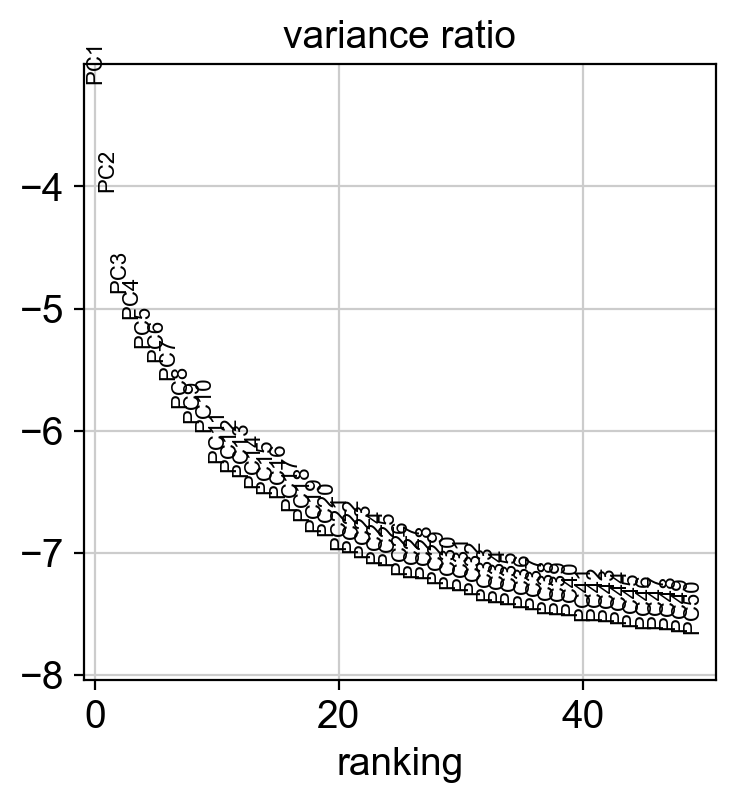

In [89]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### Computing the neighborhood graph

In [90]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Embedding the neighborhood graph

In [91]:
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [92]:
# # Code needs to be changed to accomadate the rare case
# # when the number of cells is reduced after filtering genes in bdata
# bdata.obsm = adata.obsm.copy()
# bdata

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


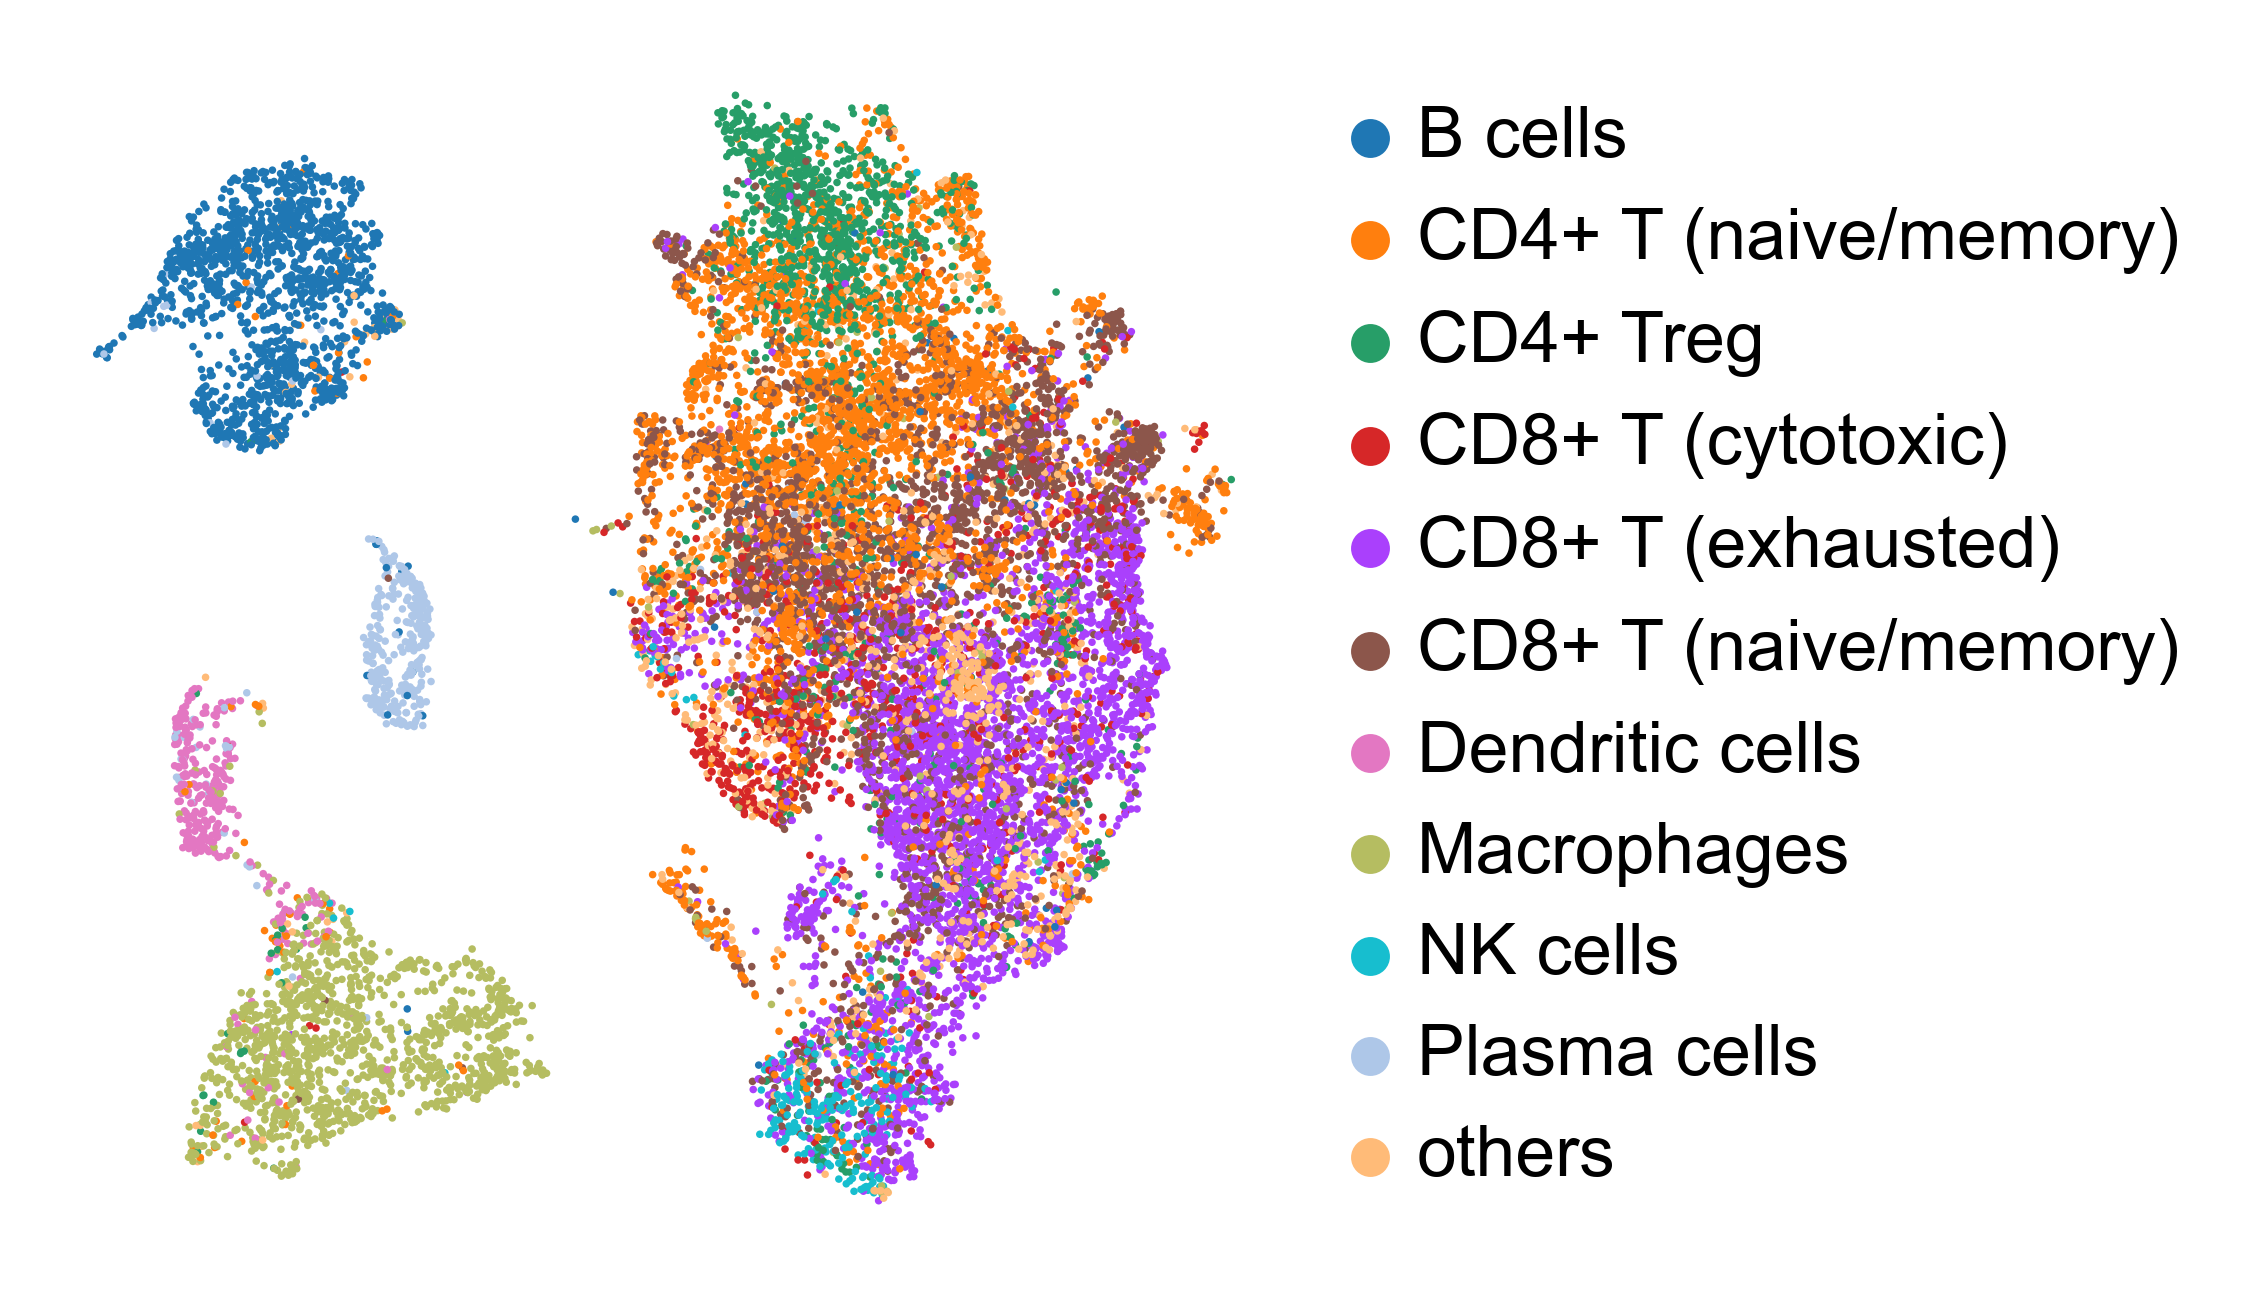

In [137]:
# sc.settings.set_figure_params(dpi=200)
# sc.pl.umap(
#     bdata,
#     color=["cell_type"],
#     frameon=False,
#     ncols=1, 
#     title=''
# )

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated")
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1, 
    title=''
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated")

In [138]:
# Save the adata
# adata.write('data/GSE120575_annotated.h5ad')

In [37]:
paper_cluster = pd.read_csv('data/cluster_number_in_paper.csv')
paper_cluster

title  cluster
0          A10_P3_M11        5
1          A11_P1_M11        5
2          A11_P3_M11        5
3          A11_P4_M11        7
4          A12_P3_M11        5
...               ...      ...
16286  H5_P5_M67_L001       11
16287  H6_P5_M67_L001       11
16288  H7_P5_M67_L001       11
16289  H8_P5_M67_L001        9
16290  H9_P5_M67_L001        5

[16291 rows x 2 columns]

In [38]:
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                                    cell_type  
title                                          
A10_P3_M11                    Dendritic c

In [93]:
adata.obs = adata.obs.drop(columns=['cluster'])
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  
title                                                                    
A10_P3_M11                 14624.809570       171.209991       1.170682  
A11_P1_M11                 11933.599609       160.350006       1.343685  
A11_P3_M11                 11877.649414       176.229980       1.483711  
A11_P4_M11                 19693.539062       146.829987       0.745574  
A12_P3_M11                  9182.320312       196.079987       2.135408  
...                                 ...              ...            ...  
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121  
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056  
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465  
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875  
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611  

[16215 rows x 13 columns]

In [94]:
pd_temp = adata.obs.merge(
    paper_cluster, 
    how='left',
    left_index=True, 
    right_on='title', 
    sort=False
)
pd_temp = pd_temp.set_index('title')
pd_temp.cluster = pd_temp.cluster.fillna(100).astype(int).astype(str)
pd_temp

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                          cluster  
title                              
A10_P3_M11                      5  
A11_P1_M11                   

In [87]:
adata.obs.index.equals(pd_temp.index)

True

In [82]:
adata.obs.index

Index(['A10_P3_M11', 'A11_P1_M11', 'A11_P3_M11', 'A11_P4_M11', 'A12_P3_M11',
       'A12_P6_M11', 'A2_P1_M11', 'A2_P4_M11', 'A3_P1_M11', 'A3_P3_M11',
       ...
       'H12_P5_M67_L001_T_enriched', 'H1_P5_M67_L001_T_enriched',
       'H2_P5_M67_L001_T_enriched', 'H3_P5_M67_L001_T_enriched',
       'H4_P5_M67_L001_T_enriched', 'H5_P5_M67_L001_T_enriched',
       'H6_P5_M67_L001_T_enriched', 'H7_P5_M67_L001_T_enriched',
       'H8_P5_M67_L001_T_enriched', 'H9_P5_M67_L001_T_enriched'],
      dtype='object', name='title', length=16215)

In [83]:
pd_temp.index

Index(['A10_P3_M11', 'A11_P1_M11', 'A11_P3_M11', 'A11_P4_M11', 'A12_P3_M11',
       'A12_P6_M11', 'A2_P1_M11', 'A2_P4_M11', 'A3_P1_M11', 'A3_P3_M11',
       ...
       'H12_P5_M67_L001_T_enriched', 'H1_P5_M67_L001_T_enriched',
       'H2_P5_M67_L001_T_enriched', 'H3_P5_M67_L001_T_enriched',
       'H4_P5_M67_L001_T_enriched', 'H5_P5_M67_L001_T_enriched',
       'H6_P5_M67_L001_T_enriched', 'H7_P5_M67_L001_T_enriched',
       'H8_P5_M67_L001_T_enriched', 'H9_P5_M67_L001_T_enriched'],
      dtype='object', name='title', length=16215)

In [95]:
adata.obs = pd_temp.copy()
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                          cluster  
title                              
A10_P3_M11                      5  
A11_P1_M11                   

In [90]:
adata.obs['cluster'] = pd_temp.cluster
adata.obs

Sample name           source name      organism  \
title                                                                         
A10_P3_M11                     Sample 1  Melanoma single cell  Homo sapiens   
A11_P1_M11                     Sample 2  Melanoma single cell  Homo sapiens   
A11_P3_M11                     Sample 3  Melanoma single cell  Homo sapiens   
A11_P4_M11                     Sample 4  Melanoma single cell  Homo sapiens   
A12_P3_M11                     Sample 5  Melanoma single cell  Homo sapiens   
...                                 ...                   ...           ...   
H5_P5_M67_L001_T_enriched  Sample 16287  Melanoma single cell  Homo sapiens   
H6_P5_M67_L001_T_enriched  Sample 16288  Melanoma single cell  Homo sapiens   
H7_P5_M67_L001_T_enriched  Sample 16289  Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched  Sample 16290  Melanoma single cell  Homo sapiens   
H9_P5_M67_L001_T_enriched  Sample 16291  Melanoma single cell  Homo sapiens   

                          sample_id       response     therapy patient_id  \
title                                                                       
A10_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P1_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A11_P4_M11                   Pre_P1      Responder  anti-CTLA4         P1   
A12_P3_M11                   Pre_P1      Responder  anti-CTLA4         P1   
...                             ...            ...         ...        ...   
H5_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H6_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H7_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H8_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   
H9_P5_M67_L001_T_enriched   Post_P6  Non-responder    anti-PD1         P6   

                          time_point  n_genes  n_genes_by_counts  \
title                                                              
A10_P3_M11                       Pre     2050               2050   
A11_P1_M11                       Pre     1573               1573   
A11_P3_M11                       Pre     1591               1590   
A11_P4_M11                       Pre     2909               2909   
A12_P3_M11                       Pre     1211               1210   
...                              ...      ...                ...   
H5_P5_M67_L001_T_enriched       Post     4355               4355   
H6_P5_M67_L001_T_enriched       Post     4948               4948   
H7_P5_M67_L001_T_enriched       Post     3208               3208   
H8_P5_M67_L001_T_enriched       Post     1355               1355   
H9_P5_M67_L001_T_enriched       Post     1686               1686   

                           total_counts  total_counts_mt  pct_counts_mt  \
title                                                                     
A10_P3_M11                 14624.809570       171.209991       1.170682   
A11_P1_M11                 11933.599609       160.350006       1.343685   
A11_P3_M11                 11877.649414       176.229980       1.483711   
A11_P4_M11                 19693.539062       146.829987       0.745574   
A12_P3_M11                  9182.320312       196.079987       2.135408   
...                                 ...              ...            ...   
H5_P5_M67_L001_T_enriched  26757.671875       157.099991       0.587121   
H6_P5_M67_L001_T_enriched  27900.060547       163.509995       0.586056   
H7_P5_M67_L001_T_enriched  20217.662109       155.770020       0.770465   
H8_P5_M67_L001_T_enriched   8411.660156       193.709991       2.302875   
H9_P5_M67_L001_T_enriched  10179.930664       178.720016       1.755611   

                           cluster  
title                               
A10_P3_M11                       5  
A11_P1_M11                

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster' as categorical


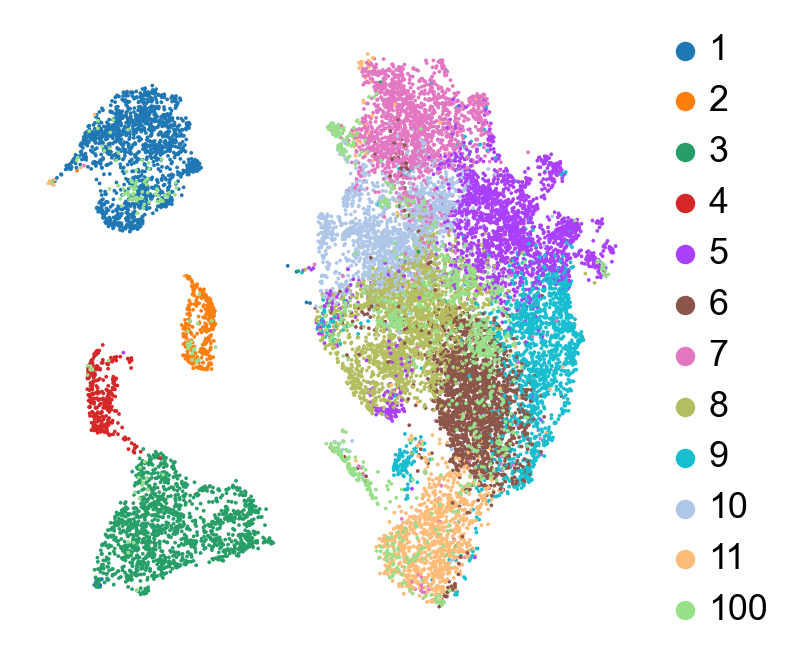

In [96]:
sc.pl.umap(adata, 
           color=['cluster'], 
           frameon=False, 
           title='')

**Change "others" to "Other lymphocytes"**

**Plot a UMAP colored by response instead of cell types**

In [ ]:
adata

In [ ]:
sc.pl.umap(adata, 
           color=['FOXP3', 'PDCD1'], 
           frameon=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        'cell_type', 
                         method='wilcoxon')
adata

In [ ]:
# !!!! This figure should have a legend to show which color stands for which
plt.figure(figsize=(9, 4), dpi=100)
sc.pl.rank_genes_groups_violin(adata, 
                               groups=['Exhausted T cells'],
                               n_genes=19)

In [ ]:
################################################

In [ ]:
################################################
# The following is as if leiden is used for clustering.

### Clustering the neighborhood graph

In [12]:
sc.tl.leiden(adata, resolution=0.25)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [17]:
# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

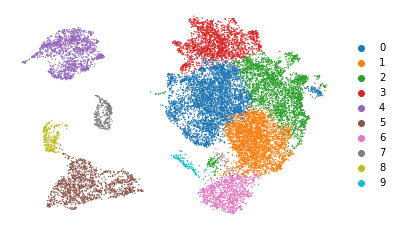

In [18]:
sc.pl.umap(adata, 
           color=['leiden'], 
           frameon=False, 
           title='')

In [22]:
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

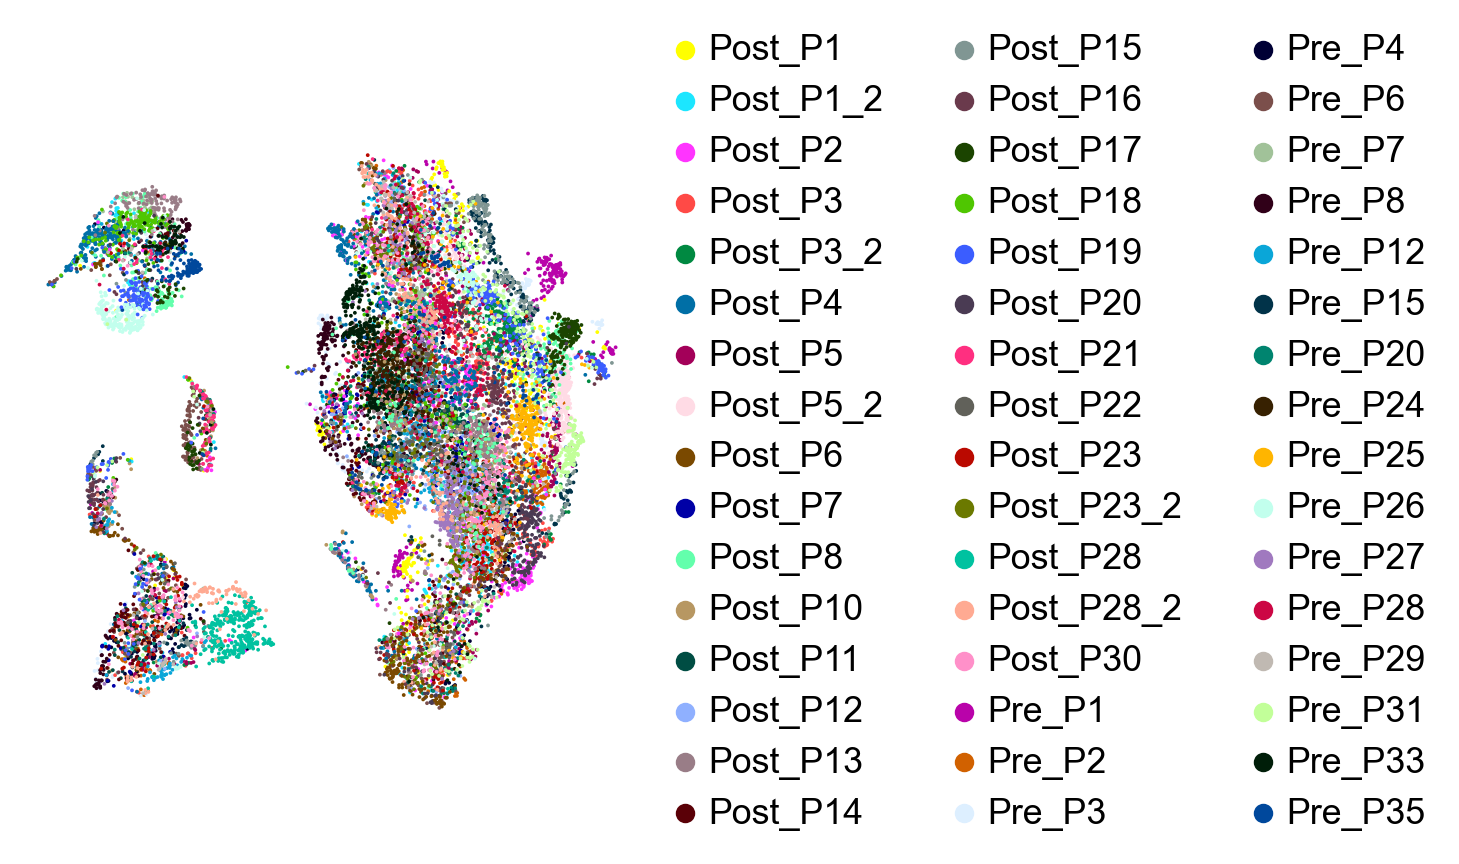

In [26]:
# Check if there is batch effect
sc.pl.umap(adata, 
           color=['sample_id'], 
           frameon=False, 
           title='')

In [38]:
# Save adata.obs
# adata.write_csvs('data/GSE120575_annotated_csvs')

writing .csv files to data/GSE120575_annotated_csvs


In [14]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [15]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)

0             1             2            3              4  \
0         MALAT1          NKG7       TNFAIP3        TRBC2        HLA-DRA   
1           IL7R          CCL5          CREM          CD4           CD74   
2           TCF7          PRF1          CCL5         TRAC          MS4A1   
3          S1PR1         KLRK1         YPEL5       SPOCK2          CD79A   
4      LINC00861          CST7         CXCR4     TNFRSF18         BCL11A   
5          TRBC2          CD3G       ZFP36L2       ARID5B  CTA-250D10.23   
6          PLAC8          CD8A         NR4A2          MAF           IRF8   
7          SORL1         TRBC2        ZNF331      TNFRSF4       HLA-DPA1   
8           TC2N          GZMA         TRBC2        CTLA4       HLA-DQB1   
9      C20orf112          CCL4         TMEM2        TIGIT          BANK1   
10         ZAP70           CD2        TMEM66          CD2           IGHM   
11        TGFBR3          TRAC           FYN        FOXP3       HLA-DRB1   
12        FLT3LG          LYST          SRGN         ICOS           CD22   
13         SAMD3          CD3D          CD8A       PBXIP1       HLA-DQA1   
14        FGFBP2          IL32         DUSP2         IL32           CD19   
15         KLRB1       PTPRCAP        TUBA4A         PIM2           CD37   
16         S1PR5         HLA-A        MALAT1          B2M       HLA-DPB1   
17         PTGDR          CTSW         FOSL2         BATF       HLA-DRB6   
18          GNLY          CD3E           EZR       TBC1D4          CD79B   
19           PXN      APOBEC3G        DNAJB1         CD28       HLA-DRB5   
20          CCL5         PDCD1       PPP2R5C      TMEM173           CD83   
21        GIMAP5          CBLB       TSC22D3        DUSP4           FGD2   
22        MGAT4A      APOBEC3C        DNAJA1        HLA-A         ADAM28   
23        GIMAP7        HAVCR2         ZFP36         ICA1          FCRL1   
24           TXK          CD8B        TSPYL2         TLK1           PAX5   
25         KLRG1         TIGIT        RNF19A         SRGN           IGKC   
26          CD3G        CCL4L1     MKLN1-AS1        PHTF2           IGHD   
27          CD69          GZMK         MYADM      ZC3H12D          NCF1C   
28        IFITM1         HLA-B         DUSP4        IL2RA          NAPSB   
29  RP11-778D9.4         PRKCH      FAM177A1        RTKN2      LINC00926   
30         DHRS3         HLA-C         KLRK1       CORO1B           NCF1   
31        RPL13A          CD27        SLC7A5        IL6ST          CIITA   
32        PTGER2         SIRPG  RP11-138A9.2        GAPDH      KIAA0226L   
33         STAT4          RGS1       HNRNPH1     TNFRSF25            LY9   
34        FAM65B         GAPDH       SLC38A2      HNRNPLL       HLA-DQA2   
35       C1orf56   RP5-940J5.9          TOB1        FBLN7          FCER2   
36          RPS3          GZMB        FAM46C        ITM2A     AC096579.7   
37         SCML4         IL2RB        CNOT6L      PHACTR2       HLA-DQB2   
38          IL32          GZMH          JUND           F5         ADAM19   
39       DENND2D     LINC00152       ZC3HAV1         CCR8           CD55   
40         KLRF1          LSP1           B2M           GK          MEF2C   
41         ANXA1          LAG3        SAMSN1        TIAM1        HLA-DMA   
42         MYBL1   KLRC4-KLRK1        VPS37B  MIR4435-1HG          NCF1B   
43         RPL13          IFNG     GABARAPL1       MAGEH1          WDFY4   
44         APBA2         KLRD1         IFRD1         CD3D          FAIM3   
45         TXNIP        IFITM1        RANBP2         SOD1           SELL   
46         GRAP2         IKZF3         HSPA8      PIK3IP1         SWAP70   
47          RORA           B2M          BRD2        NR3C1         SYNGR2   
48       RPL10P3           LCK         JMJD6          CD5        HLA-DMB   
49     LINC00612  RP11-94L15.2         RGPD5        THADA           TCF4   

                5               6           7             8         9  
0           IFI30           STMN1        SSR4         PTPRS      G

In [57]:
# sc.pl.rank_genes_groups_violin(adata)

In [2]:
adata = sc.read_h5ad('data/GSE120575_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)

B cells   CD8+ T cells Dendritic cells Monocytes/Macrophages  \
0           MS4A1           CD8A          TYROBP                  CD68   
1           CD79A           CD8B          FCER1G                TYROBP   
2         HLA-DRA          KLRK1            CST3                FCER1G   
3          BCL11A           CCL5           TGFBI                 IFI30   
4   CTA-250D10.23           NKG7             GRN                  CST3   
5           BANK1          TRBC2           PTPRE                   LYZ   
6            IRF8           CST7            IRF8         RP11-1143G9.4   
7            CD74           PRF1           MPEG1                  AIF1   
8            IGHM           CTSW            NPC2                  CTSB   
9            CD19           CD3G            PLEK                   GRN   
10       HLA-DQB1    KLRC4-KLRK1           ITGAX               S100A11   
11           CD22          CD8BP            CD68              SERPINA1   
12       HLA-DQA1           TRAC         THEMIS2                  NPC2   
13          CD79B           GZMA            PSAP                  PSAP   
14           FGD2           CCL4            FGD2                CLEC7A   
15       HLA-DPA1           CD3E           NAPSB                  GPX1   
16          FCRL1           GZMH            GPX1                 PLAUR   
17         ADAM28          KLRD1          LILRB4                 ANXA2   
18           CD37           IL32            THBD                 TGFBI   
19           CD83            FYN          RNF130                FCGR2A   
20       HLA-DPB1          KLRC4            CYBB               HLA-DRA   
21           PAX5           GZMK            PLD4                  CTSS   
22           IGHD           CD3D          RNASE6                LGALS3   
23       HLA-DRB1         CCL4L1          MS4A6A                  GLUL   
24           IGKC            CD2           CIITA                  CD14   
25      LINC00926          PRKCH             GSN                   HCK   
26          NCF1C           CBLB           FCGRT                 CSF1R   
27       HLA-DRB6           GZMB          CSF2RA                LGALS1   
28          NAPSB       APOBEC3G          GPR183                 FTLP3   
29           NCF1          CRTAM          CDKN1A                   FTL   
30          CIITA           LAG3            CTSB                RNF130   
31       HLA-DRB5  RP11-291B21.2           PLAC8                 TIMP1   
32      KIAA0226L           LYST             CD4                LILRB2   
33          FCER2         CCL4L2         HLA-DRA                 ITGAX   
34            LY9          VCAM1         HLA-DMB               ANXA2P2   
35     AC096579.7            ID2           PLAUR                  CTSH   
36          MEF2C          HLA-A            CTSS                  CYBB   
37          NCF1B          IL2RB           NR4A3                 FCGRT   
38       HLA-DQA2           IFNG          DPYSL2                  LST1   
39       HLA-DQB2          TRGC2          MAN2B1               S100A10   
40          WDFY4         THEMIS            CD83                  LRP1   
41           SELL            CD7           SH2B3                  CD63   
42         SWAP70            LCK          CORO1C                  FTH1   
43           CD55          PDCD1           IL3RA                 ANXA5   
44         ADAM19        PTPRCAP             SYK                IFNGR2   
45          FAIM3           CD96           ALDH2                  SAT1   
46        RALGPS2         IFITM1         CCDC88A                 PILRA   
47        FAM129C          HLA-B          SAMHD1                  TPP1   
48            BLK          ZAP70          CSF2RB                PLXDC2   
49           TCF4        TNFRSF9        SERPINF1                  NCF2   

          NK cells Plasma cells Regulatory T cells       others  
0            STMN1          IGJ              FOXP3         IL7R  
1   RP11-386G11.10        DERL3              IL2RA        TRBC2  
2             RRM2         MZB1      

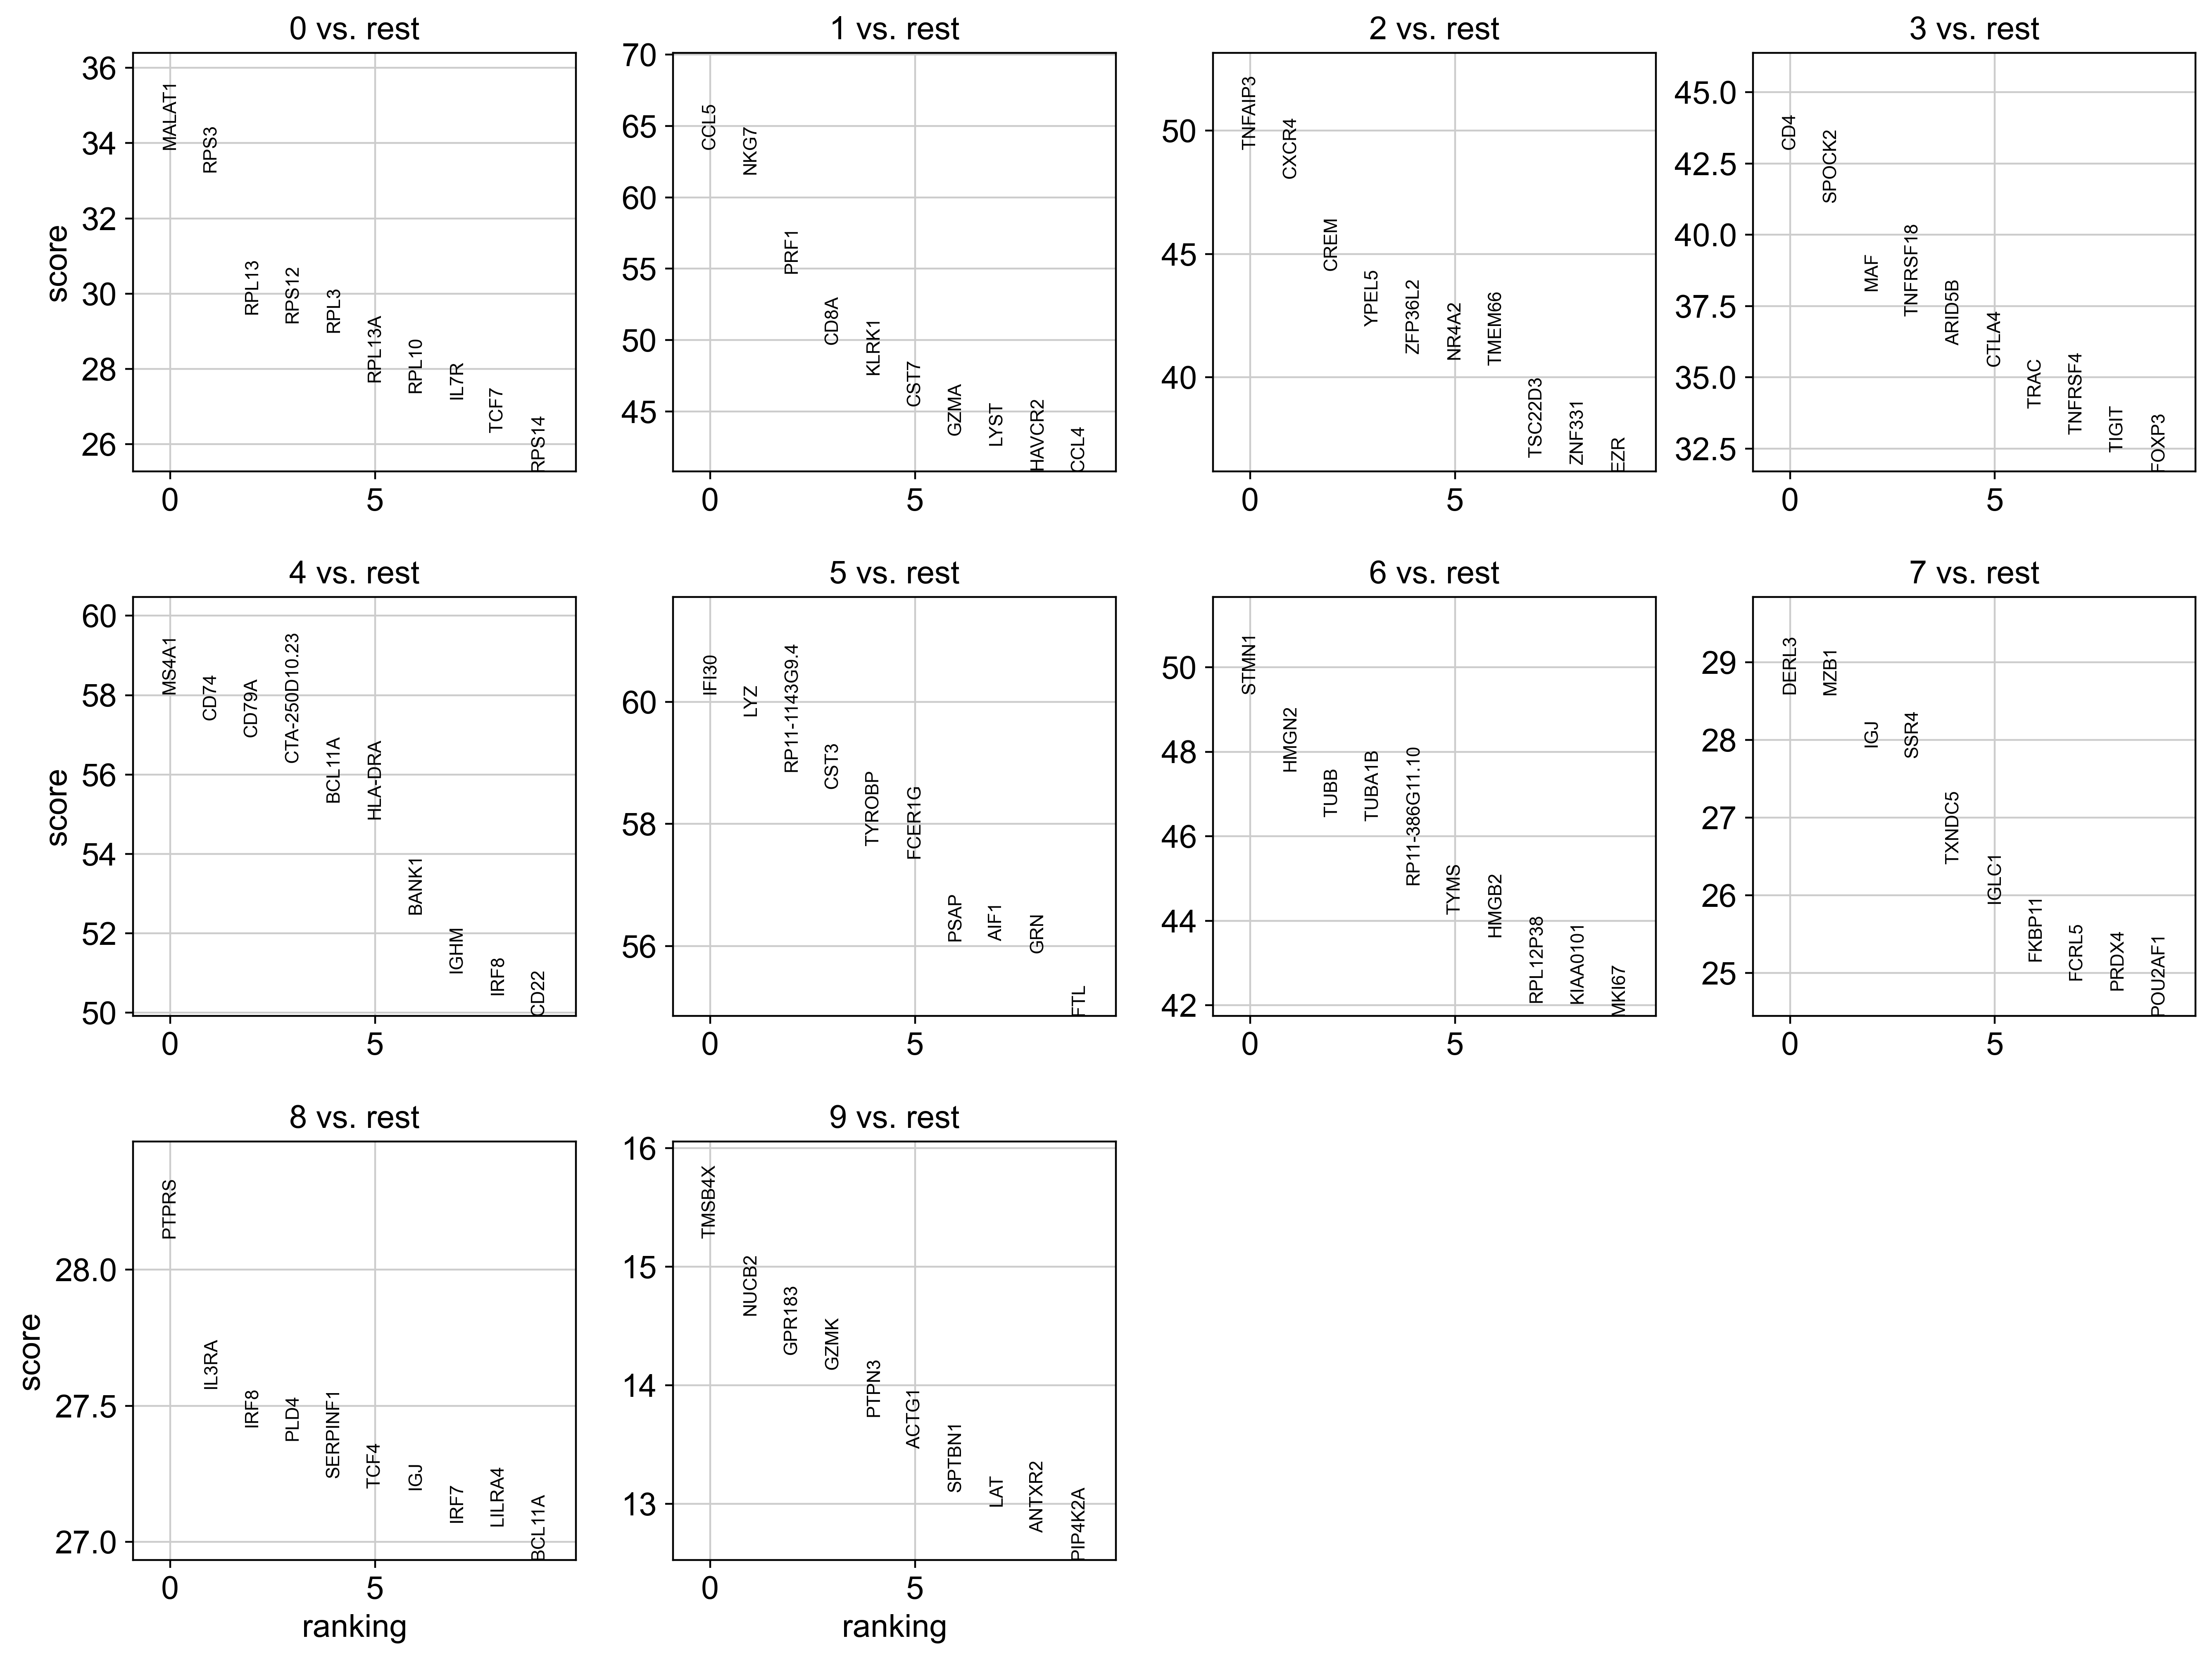

In [42]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0       1        2         3              4              5  \
0  MALAT1    CCL5  TNFAIP3       CD4          MS4A1          IFI30   
1    RPS3    NKG7    CXCR4    SPOCK2           CD74            LYZ   
2   RPL13    PRF1     CREM       MAF          CD79A  RP11-1143G9.4   
3   RPS12    CD8A    YPEL5  TNFRSF18  CTA-250D10.23           CST3   
4    RPL3   KLRK1  ZFP36L2    ARID5B         BCL11A         TYROBP   
5  RPL13A    CST7    NR4A2     CTLA4        HLA-DRA         FCER1G   
6   RPL10    GZMA   TMEM66      TRAC          BANK1           PSAP   
7    IL7R    LYST  TSC22D3   TNFRSF4           IGHM           AIF1   
8    TCF7  HAVCR2   ZNF331     TIGIT           IRF8            GRN   
9   RPS14    CCL4      EZR     FOXP3           CD22            FTL   

                6        7         8        9  
0           STMN1    DERL3     PTPRS   TMSB4X  
1           HMGN2     MZB1     IL3RA    NUCB2  
2            TUBB      IGJ      IRF8   GPR183  
3          TUBA1B     SSR4      PLD4     GZMK  
4  RP11-386G11.10   TXNDC5  SERPINF1    PTPN3  
5            TYMS    IGLC1      TCF4    ACTG1  
6           HMGB2   FKBP11       IGJ   SPTBN1  
7        RPL12P38    FCRL5      IRF7      LAT  
8        KIAA0101    PRDX4    LILRA4   ANTXR2  
9           MKI67  POU2AF1    BCL11A  PIP4K2A

- 2 B cell clusters (G1- B cells; G2- plasma cells), 
- 2 myeloid clusters (G3- monocytes and/or macrophages; G4- dendritic cells) 
- 7 clusters enriched for T/NK/NKT cells (G5–11)

In [44]:
# set() removes duplicate; then list() converts back to a list
# marker_genes = list(set(['IGHD', 'CD19', 'CD22', # B-cells
#                          'SDC1', 'IGLV6-57', # Plasma cells
#                          'MARCO', 'CD300E', # Monocytes/Macrophages
#                          'PTCRA', 'CLEC4C', # Dendritic cells
#                          'LMNA', 'IL7R', # Lymphocytes
#                          'CD8A', 'CD8B', # Exhausted CD8+ T-cells
#                          'FOXP3', 'CD4', # Regulatory T-cells
#                          'FGFBP2', 'TGFBR3', # Cytotoxic T-cells
#                          'VCAM1', 'CTLA4', # Exhausted/HS CD8+ T-cells
#                          'LEF1', 'IL7R', # Memory T-cells
#                          'SPC25', 'CDCA5' # Exhausted lymphocytes
# #                 'CD3E', 'CD2', # T cells
# #                 'CD4', 'CD3E', # CD4 T cells
# #                 'CD8A', 'CD8B', # CD8 T cells
# #                 'FOXP3', 'CD3E', 'CTLA4', 'IL2RA' # Regulatory T cells
# #                 'FOXP3', 'CD3E', 'CD4', # Regulatory CD4 T cells
# #                 'FOXP3', 'CD3E', 'CD8A', 'CD8B'# Regulatory CD8 T cells
# #                 'FOXP3', 'CD3E', 'CD4', 'CD8A', 'CD8B'# Regulatory CD4/CD8 T cells
# #                 'CD3E', 'NCR1', 'NCAMa', # NKT cells
# #                 'FCGR3A', # NK cells
# #                 'CD3E', 'CD2', 'CD28' # Activated T cells
#                ]))
marker_genes = list(OrderedDict.fromkeys(['IGHD', 'CD19', 'CD22', # B-cells
                         'SDC1', 'HID1', # Plasma cells
                         'MARCO', 'CD300E', # Monocytes/Macrophages
                         'PTCRA', 'CLEC4C', # Dendritic cells
                         'IL7R', # Lymphocytes
                         'CD8A', 'CD8B', # Exhausted CD8+ T-cells
                         'FOXP3', 'CD4', # Regulatory T-cells
                         'FGFBP2', 'TGFBR3', # Cytotoxic T-cells
                         'VCAM1', 'CTLA4', # Exhausted/HS CD8+ T-cells
                         'LEF1', 'IL7R', # Memory T-cells
                         'SPC25', 'CDCA5' # Exhausted lymphocytes
                                         ]))
marker_genes

['IGHD',
 'CD19',
 'CD22',
 'SDC1',
 'HID1',
 'MARCO',
 'CD300E',
 'PTCRA',
 'CLEC4C',
 'IL7R',
 'CD8A',
 'CD8B',
 'FOXP3',
 'CD4',
 'FGFBP2',
 'TGFBR3',
 'VCAM1',
 'CTLA4',
 'LEF1',
 'SPC25',
 'CDCA5']

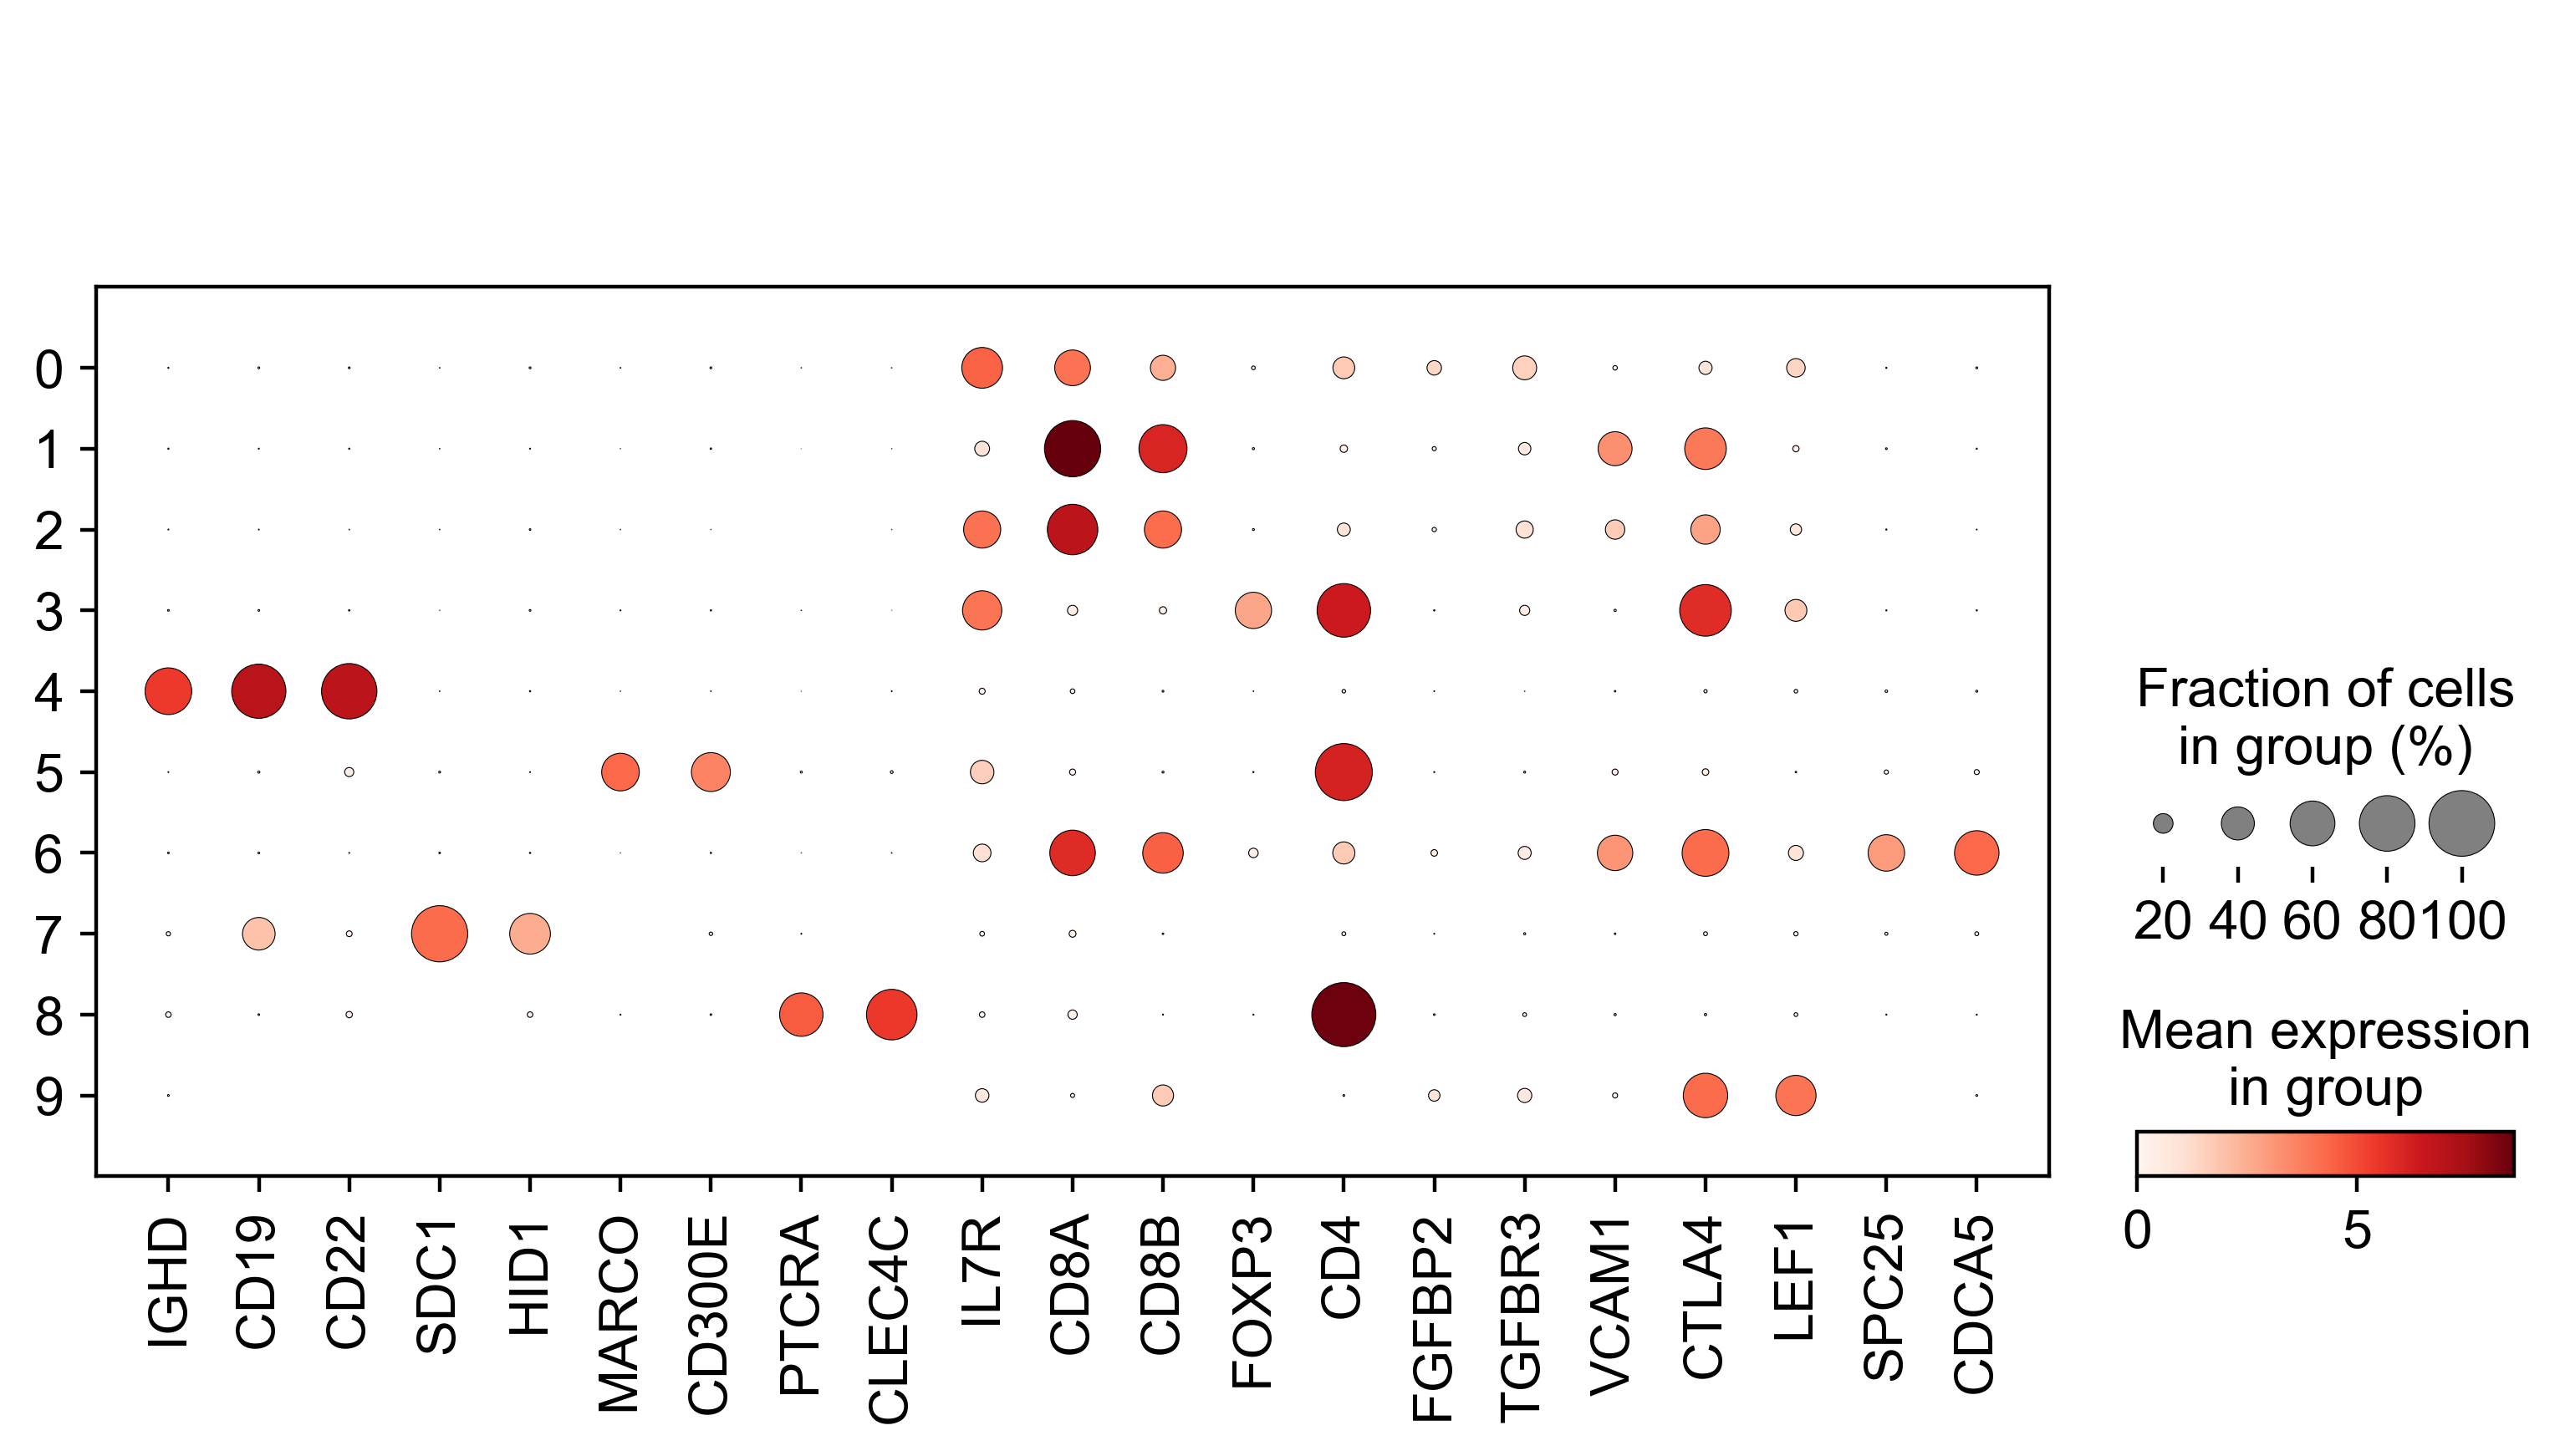

In [45]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

00 

01 

02

03 

04 B-cells

05 Monocytes/Macrophages

06

07 Plasma cells

08 Dendritic cells

09

10